In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing libraries

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model


loading and preprocessing the data

In [8]:
def normalize_filename(filename):
    """
    Normalizes filenames for matching images and masks.
    Removes extensions and handles '_mask' naming convention.
    """
    # Remove extension and "_mask" if present
    if "_mask" in filename:
        return filename.split("_mask")[0]
    return filename.split(".")[0]

def load_data(image_dir, mask_dir, img_size=(256, 256)):
    """
    Loads and preprocesses images and masks, handling missing files.
    """
    images, masks = [], []
    missing_images, missing_masks = [], []

    # Collect all normalized filenames from image and mask directories
    image_files = {normalize_filename(f): f for f in os.listdir(image_dir) if f.endswith(".png")}
    mask_files = {normalize_filename(f): f for f in os.listdir(mask_dir) if f.endswith(".png")}

    # Find missing pairs
    all_keys = set(image_files.keys()).union(mask_files.keys())
    for key in tqdm(all_keys, desc="Processing file pairs"):
        if key in image_files and key in mask_files:
            # Load and preprocess image
            img_path = os.path.join(image_dir, image_files[key])
            mask_path = os.path.join(mask_dir, mask_files[key])

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=img_size)
            mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0

            images.append(img)
            masks.append(mask)
        elif key not in image_files:
            missing_images.append(key)
        elif key not in mask_files:
            missing_masks.append(key)

    print(f"Total Missing Images: {len(missing_images)}")
    print(f"Total Missing Masks: {len(missing_masks)}")

    return np.array(images), np.array(masks), missing_images, missing_masks



paths

In [9]:
# Paths to images and masks
image_dir = "/content/drive/MyDrive/CS6353/Project/Datasets/shcxr-lung-mask/images"
mask_dir = "/content/drive/MyDrive/CS6353/Project/Datasets/shcxr-lung-mask/mask"

# Load data
images, masks, missing_images, missing_masks = load_data(image_dir, mask_dir)

# Visualize missing files
if missing_images:
    print(f"Missing Image Files:\n{missing_images}")
if missing_masks:
    print(f"Missing Mask Files:\n{missing_masks}")


Processing file pairs: 100%|██████████| 662/662 [04:41<00:00,  2.35it/s]


Total Missing Images: 0
Total Missing Masks: 96
Missing Mask Files:
['CHNCXR_0359_1', 'CHNCXR_0202_0', 'CHNCXR_0351_1', 'CHNCXR_0489_1', 'CHNCXR_0565_1', 'CHNCXR_0344_1', 'CHNCXR_0355_1', 'CHNCXR_0346_1', 'CHNCXR_0494_1', 'CHNCXR_0488_1', 'CHNCXR_0356_1', 'CHNCXR_0184_0', 'CHNCXR_0348_1', 'CHNCXR_0353_1', 'CHNCXR_0345_1', 'CHNCXR_0564_1', 'CHNCXR_0188_0', 'CHNCXR_0197_0', 'CHNCXR_0485_1', 'CHNCXR_0481_1', 'CHNCXR_0499_1', 'CHNCXR_0563_1', 'CHNCXR_0341_1', 'CHNCXR_0490_1', 'CHNCXR_0209_0', 'CHNCXR_0190_0', 'CHNCXR_0038_0', 'CHNCXR_0194_0', 'CHNCXR_0350_1', 'CHNCXR_0498_1', 'CHNCXR_0205_0', 'CHNCXR_0025_0', 'CHNCXR_0561_1', 'CHNCXR_0495_1', 'CHNCXR_0343_1', 'CHNCXR_0493_1', 'CHNCXR_0065_0', 'CHNCXR_0204_0', 'CHNCXR_0040_0', 'CHNCXR_0357_1', 'CHNCXR_0560_1', 'CHNCXR_0216_0', 'CHNCXR_0036_0', 'CHNCXR_0492_1', 'CHNCXR_0484_1', 'CHNCXR_0214_0', 'CHNCXR_0505_1', 'CHNCXR_0352_1', 'CHNCXR_0198_0', 'CHNCXR_0208_0', 'CHNCXR_0215_0', 'CHNCXR_0185_0', 'CHNCXR_0191_0', 'CHNCXR_0482_1', 'CHNCXR_0182_

In [11]:
def augment_data(images, masks, seed=42):
    """
    Applies advanced data augmentation to images and masks.
    """
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    augmented_images, augmented_masks = [], []

    for img, mask in tqdm(zip(images, masks), total=len(images), desc="Augmenting Data"):
        img_gen = datagen.flow(np.expand_dims(img, axis=0), batch_size=1, seed=seed)
        mask_gen = datagen.flow(np.expand_dims(mask, axis=0), batch_size=1, seed=seed)

        for _ in range(5):  # Generate 5 augmentations per sample
            augmented_images.append(next(img_gen)[0])  # Use next() to get the batch
            augmented_masks.append(next(mask_gen)[0])  # Use next() to get the batch

    return np.array(augmented_images), np.array(augmented_masks)





In [12]:
# Improved U-Net with Residual Connections
def residual_unet(input_shape=(256, 256, 3)):
    """
    Defines a U-Net with residual connections.
    """
    def conv_block(input_tensor, num_filters):
        x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    inputs = Input(input_shape)
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    bottleneck = conv_block(p4, 1024)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [13]:
aug_images, aug_masks = augment_data(images, masks)


Augmenting Data: 100%|██████████| 566/566 [00:46<00:00, 12.20it/s]


In [14]:
 #Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(aug_images, aug_masks, test_size=0.2, random_state=42)


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 89s 298ms/step - accuracy: 0.8217 - loss: 0.4030 - val_accuracy: 0.7177 - val_loss: 0.5785
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9666 - loss: 0.1314 - val_accuracy: 0.7206 - val_loss: 0.6779
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9679 - loss: 0.1103 - val_accuracy: 0.8374 - val_loss: 0.4333
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9693 - loss: 0.0949 - val_accuracy: 0.9585 - val_loss: 0.1155
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9690 - loss: 0.0860 - val_accuracy: 0.9690 - val_loss: 0.0805
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9702 - loss: 0.0764 - val_accuracy: 0.9660 - val_loss: 0.0852
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9701 - loss: 0.0718 - val_accuracy: 0.9691 - val_loss: 0.0724
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9701 - loss: 0

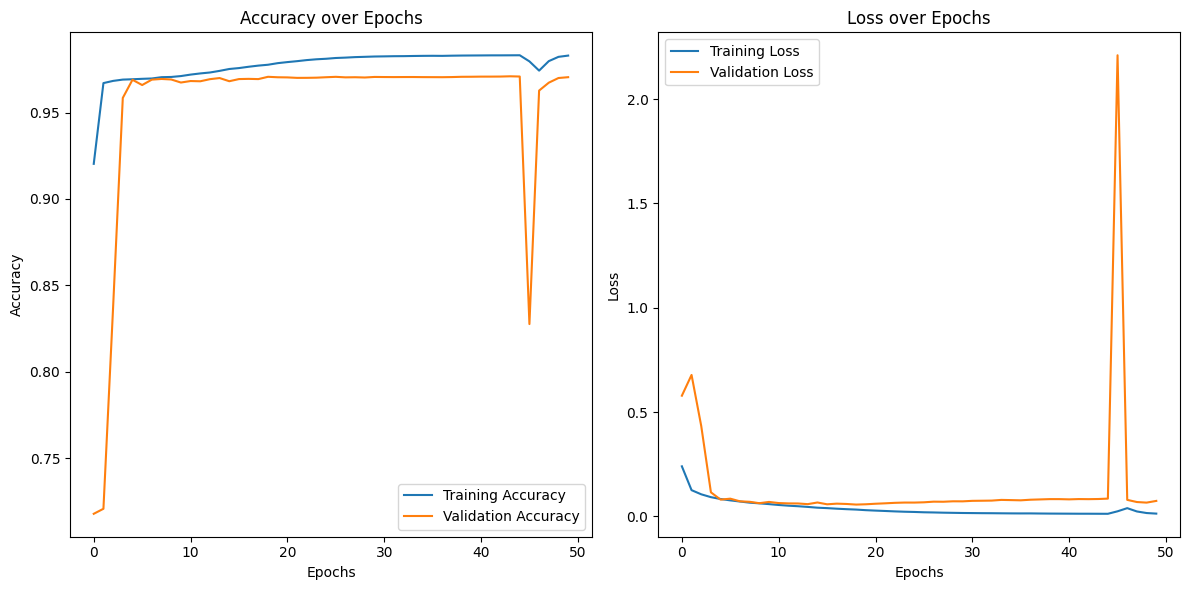

18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step


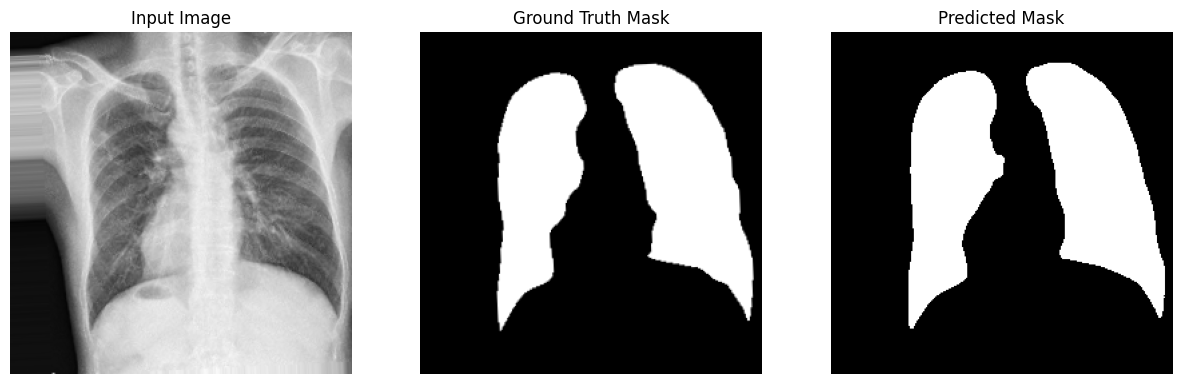

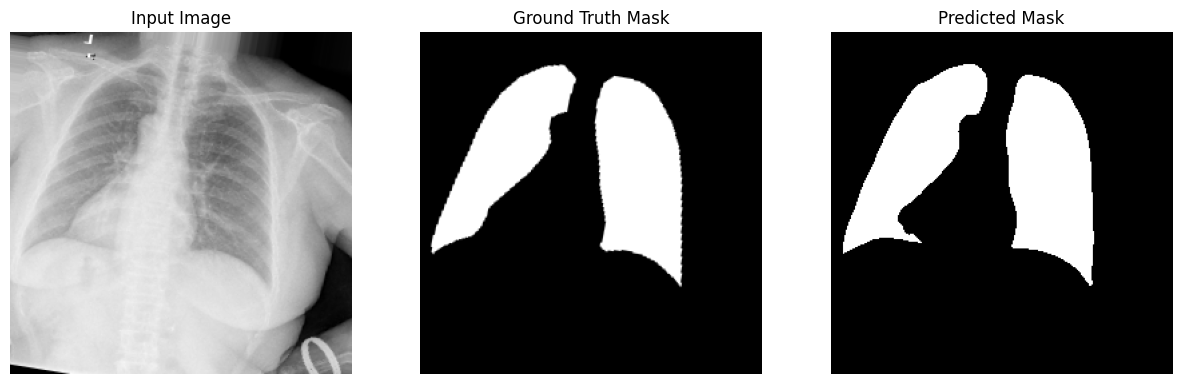

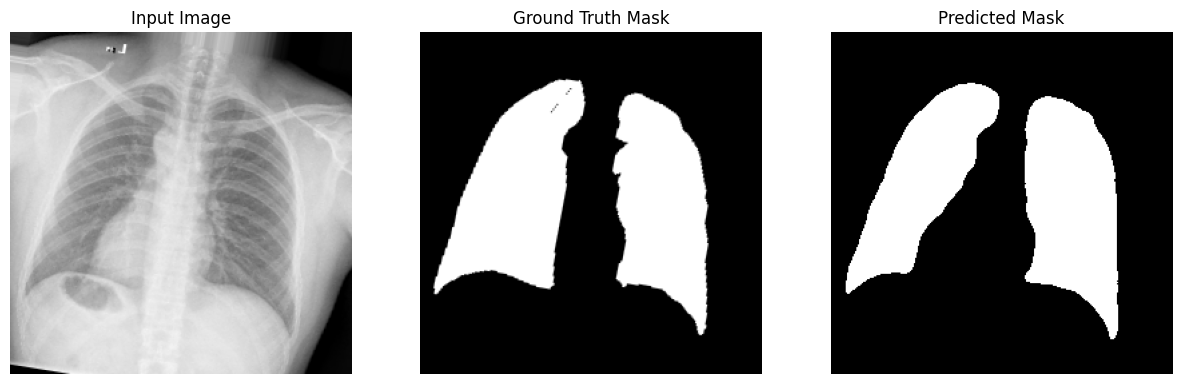

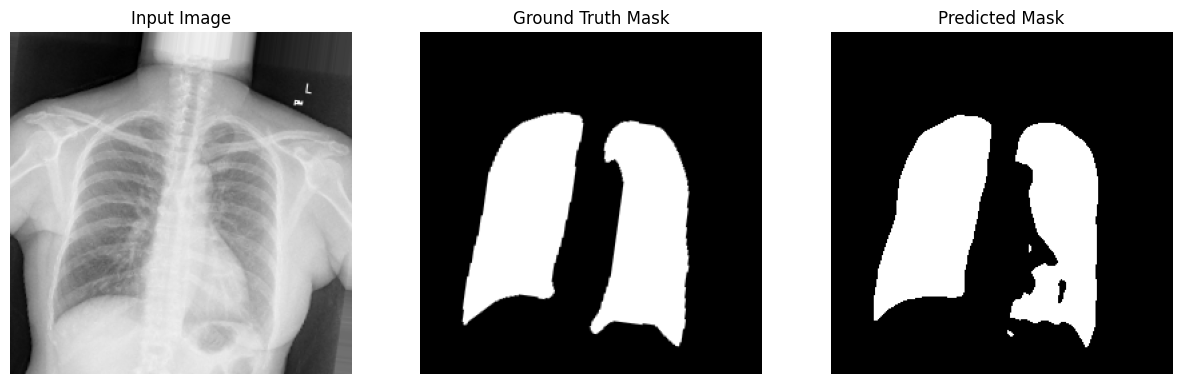

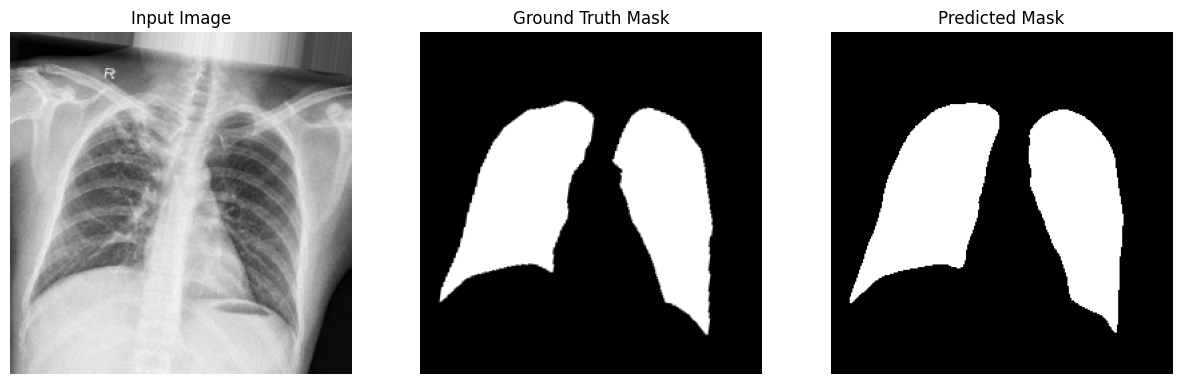

Average Dice Score: 0.9624
Average IoU Score: 0.9284
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


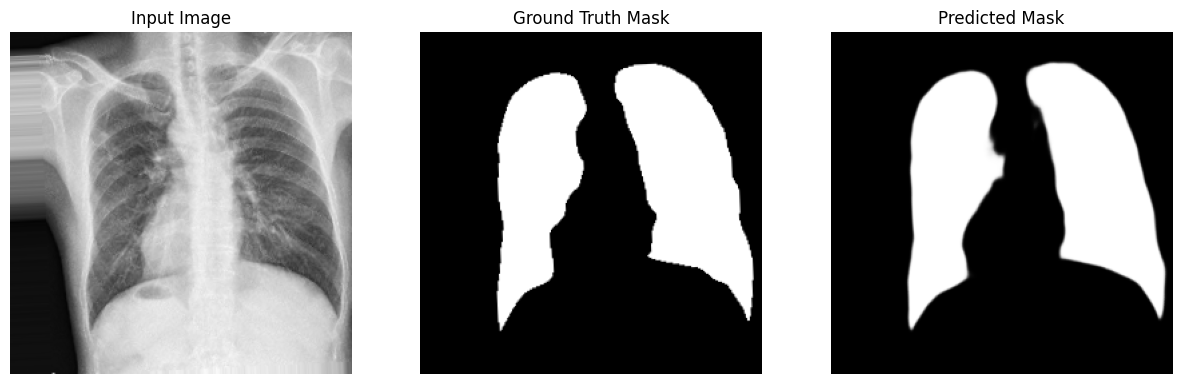

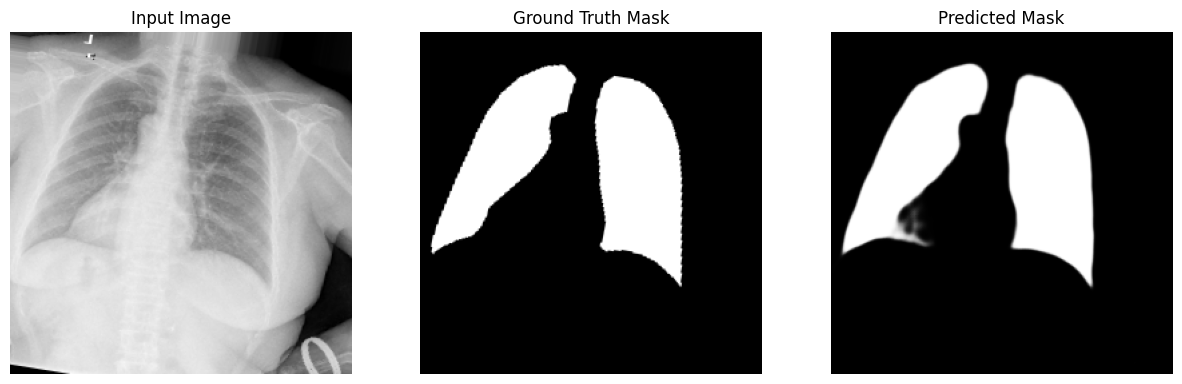

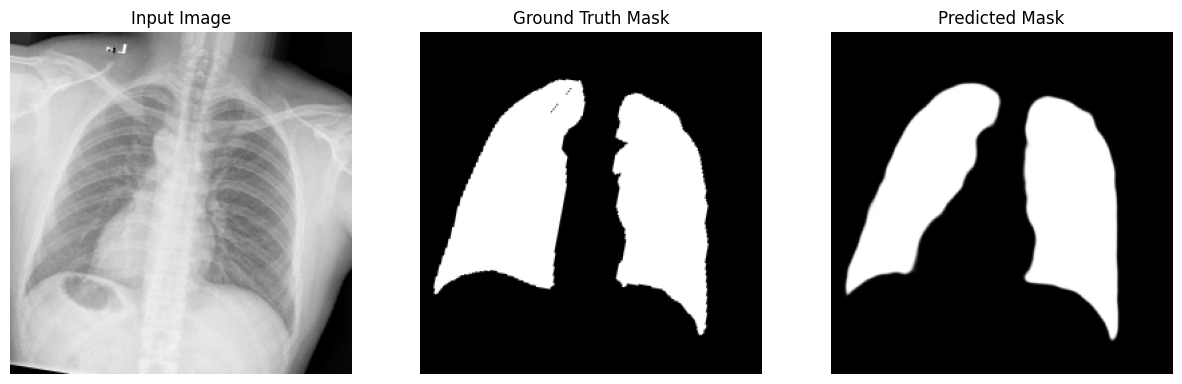

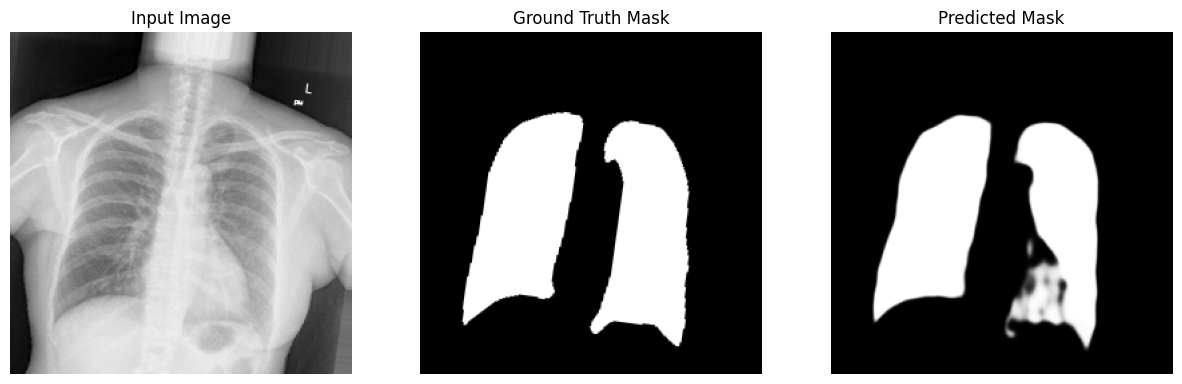

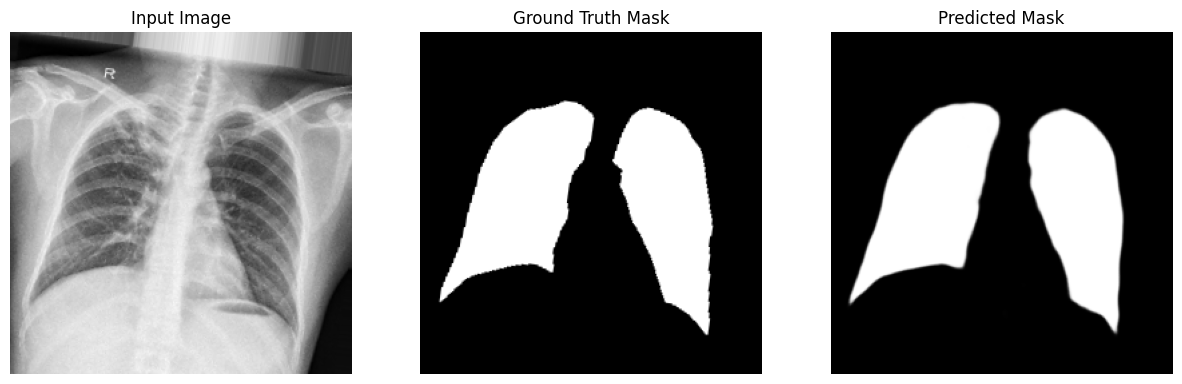

In [15]:




# Define Dice Score
def compute_dice_score(y_true, y_pred):
    """
    Computes Dice Score for evaluating segmentation performance.
    """
    smooth = 1e-6  # To prevent division by zero
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

# Define IoU Score
def compute_iou_score(y_true, y_pred):
    """
    Computes Intersection over Union (IoU) for evaluating segmentation performance.
    """
    smooth = 1e-6  # To prevent division by zero
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Visualize Training and Validation Accuracy/Loss
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss over epochs.
    """
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize Input Images, Ground Truth, and Predictions
def visualize_results(images, masks, predictions, num_samples=5):
    """
    Visualizes input images, ground truth masks, and predictions.
    """
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()
# Model Compilation and Training
model = residual_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)
# Visualize Training History
plot_training_history(history)

# Make Predictions on Validation Set
predictions = model.predict(X_val)
predictions = (predictions > 0.5).astype(np.float32)  # Convert probabilities to binary masks

# Visualize Results
visualize_results(X_val, y_val, predictions)

# Compute and Display Metrics
dice_scores = []
iou_scores = []
for i in range(len(X_val)):
    dice_scores.append(compute_dice_score(y_val[i], predictions[i]))
    iou_scores.append(compute_iou_score(y_val[i], predictions[i]))

print(f"Average Dice Score: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")

# Evaluate Model
predictions = model.predict(X_val)
visualize_results(X_val, y_val, predictions)


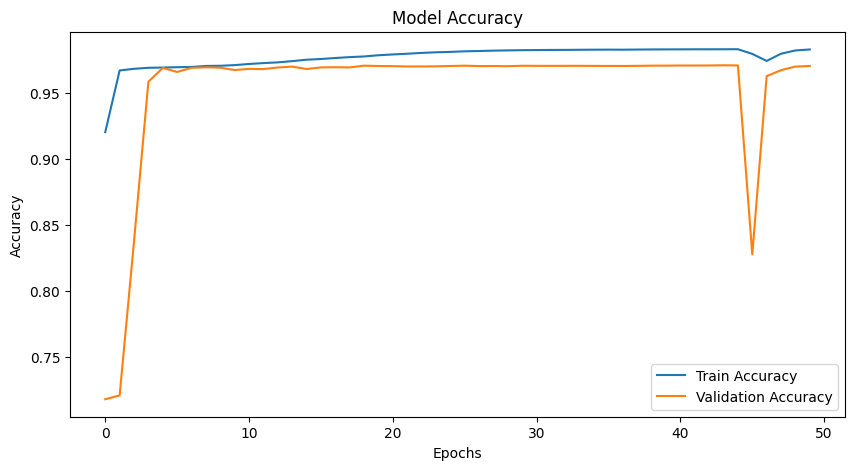

In [16]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

def load_test_data(image_dir, mask_dir, img_size=(256, 256)):
    """
    Loads and preprocesses test images and masks.
    """
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Load and preprocess mask
        mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=img_size)
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [19]:
def compute_dice_score1(y_true, y_pred):
    """
    Computes Dice Score for evaluating segmentation performance.
    """
    smooth = 1e-6  # To prevent division by zero
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

def compute_iou_score1(y_true, y_pred):
    """
    Computes Intersection over Union (IoU) for evaluating segmentation performance.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    return intersection / union

def visualize_results1(images, masks, predictions, num_samples=5):
    """
    Visualizes input images, ground truth masks, and predictions.
    """
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

In [20]:
# Paths to test images and masks
test_image_dir = "/content/drive/MyDrive/CS6353/Project/Datasets/jsrt/cxr"
test_mask_dir = "/content/drive/MyDrive/CS6353/Project/Datasets/jsrt/masks"

# Load test dataset
test_images, test_masks = load_test_data(test_image_dir, test_mask_dir)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Average Dice Score: 0.9070
Average IoU Score: 0.8410


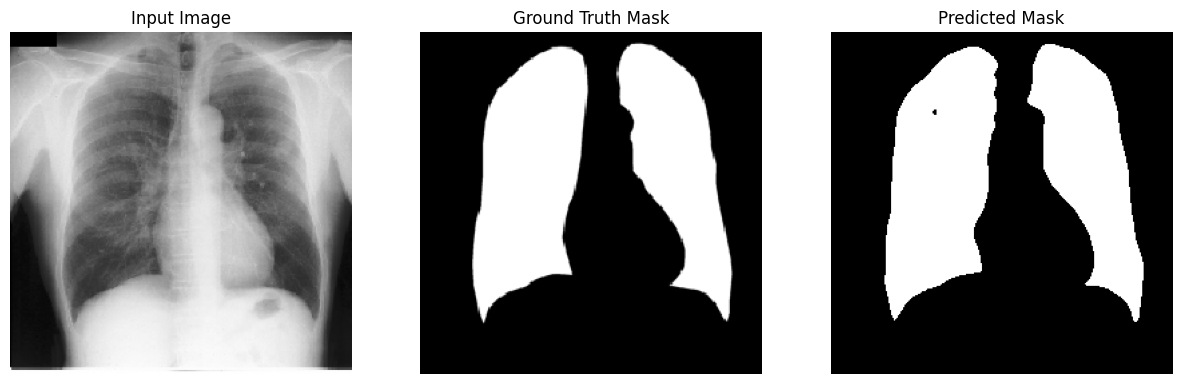

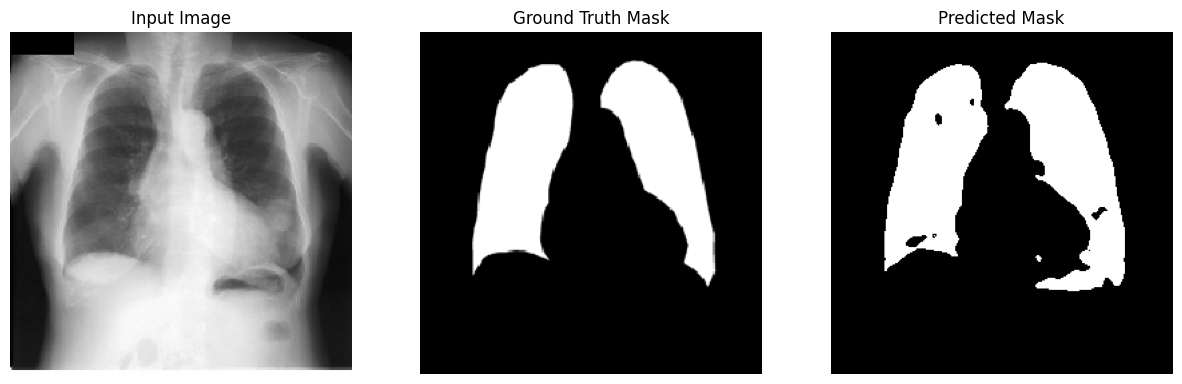

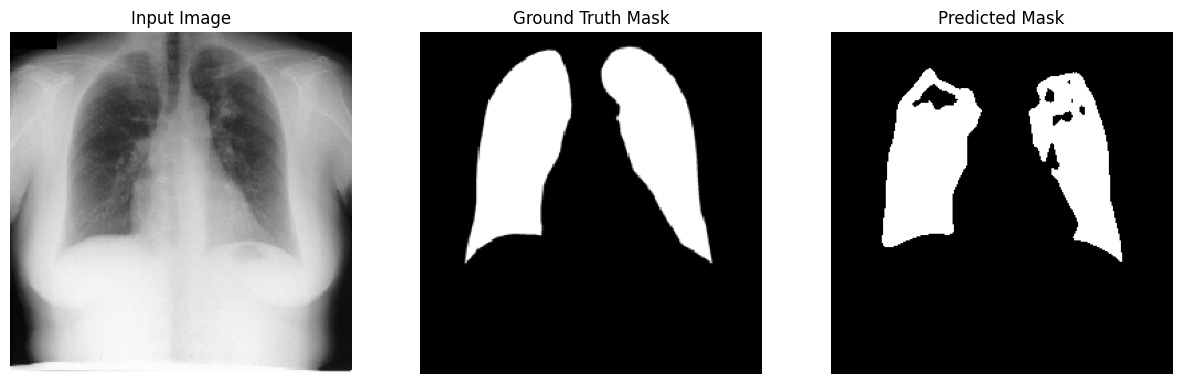

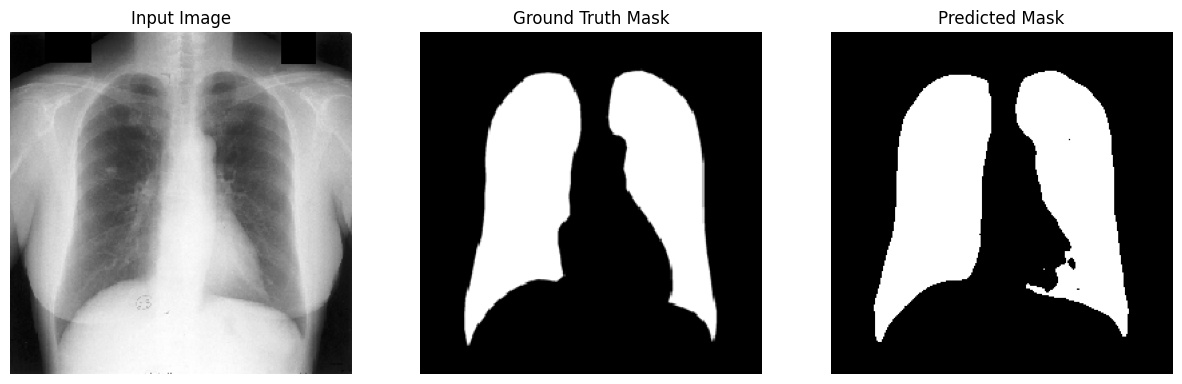

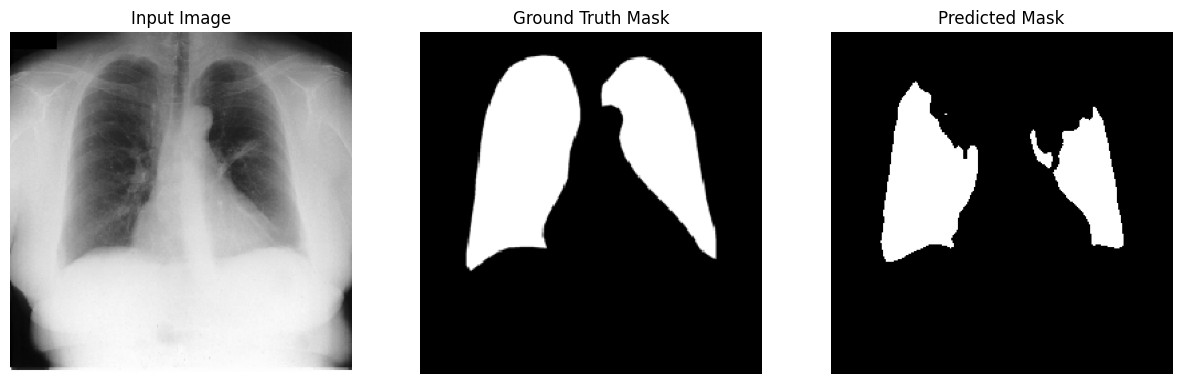

In [22]:
# Use the in-memory trained model to predict masks
predicted_masks1 = model.predict(test_images)

# Threshold predictions for binary masks
predicted_masks1 = (predicted_masks1 > 0.5).astype(np.float32)

# Evaluate performance metrics
dice_scores1 = [compute_dice_score1(test_masks[i], predicted_masks1[i]) for i in range(len(test_images))]
iou_scores1 = [compute_iou_score1(test_masks[i], predicted_masks1[i]) for i in range(len(test_images))]

# Average metrics
average_dice_score1 = np.mean(dice_scores1)
average_iou_score1 = np.mean(iou_scores1)

print(f"Average Dice Score: {average_dice_score1:.4f}")
print(f"Average IoU Score: {average_iou_score1:.4f}")

# Visualize some results
visualize_results1(test_images, test_masks, predicted_masks1, num_samples=5)